# PinSAGE with Globo Dataset and TimedLastItemPrediction Scenario

In this notebook, the implementation of PinSAGE in RecPack and the experimental part to generate the results of the algorithm will be presented. 
The notebook contains:
1. The implementation of PinSAGE in RecPack.
2. The 10% of Globo Dataset from RecPack and the TimedLastItemPrediction Scenario has been used to split the data.
3. The TimedLastItemPrediction Scenario to split the data.
4. The RecPack Pipeline Builder to run the experiments, including the splitted dataset, the algorithms and metrics to run. Hyperparameter has been performed in the Pipeline.

Please make sure you have installed all the latest libraries in your Python environment, in order to have a successful run of the code.

## PinSAGE implementation in RecPack

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_sparse import SparseTensor, matmul
from recpack.algorithms.base import TorchMLAlgorithm
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.algorithms.loss_functions import bpr_loss, bpr_max_loss
from recpack.algorithms.samplers import PositiveNegativeSampler
from recpack.matrix.util import to_csr_matrix 
from scipy.sparse import csr_matrix, lil_matrix
from typing import List, Optional
import logging

logger = logging.getLogger(__name__)

# PinSAGEConv: A single convolutional layer for the PinSAGE model
class PinSAGEConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        """
        Initialize the PinSAGEConv layer.

        Args:
            in_channels (int): Number of input channels (dimensions of the input features).
            out_channels (int): Number of output channels (dimensions of the output features).
            dropout (float): Dropout rate for regularization.
        """
        super(PinSAGEConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout

        # Define a linear transformation and a dropout layer
        self.linear = nn.Linear(in_channels, out_channels)
        self.dropout_layer = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters of the layer using Xavier uniform initialization.
        """
        nn.init.xavier_uniform_(self.linear.weight)
        if self.linear.bias is not None:
            nn.init.zeros_(self.linear.bias)

    def forward(self, x, graph):
        """
        Forward pass for the PinSAGEConv layer.

        Args:
            x (torch.Tensor): Input feature matrix.
            graph (SparseTensor): Sparse adjacency matrix representing the graph.

        Returns:
            torch.Tensor: Output features after convolution and activation.
        """
        try:
            out = matmul(graph, x)  # Perform graph convolution
        except RuntimeError as e:
            # Log the error and return the input unchanged if the operation fails
            # logger.error(f"matmul failed with error: {e}")
            return x  
        out = self.linear(out)
        out = torch.relu(out)
        out = self.dropout_layer(out)
        
        return out

# PinSAGE: A model implementation based on the PinSAGE algorithm
class PinSAGE(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, n_layers=2, dropout=0.0):
        """
        Initialize the PinSAGE model.

        Args:
            num_users (int): Number of users.
            num_items (int): Number of items.
            embedding_dim (int): Dimension of the embedding vectors.
            n_layers (int): Number of PinSAGEConv layers.
            dropout (float): Dropout rate for regularization.
        """
        super(PinSAGE, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.dropout = dropout

        # Initialize user and item embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # Create a list of PinSAGEConv layers
        self.convs = nn.ModuleList([
            PinSAGEConv(embedding_dim, embedding_dim, dropout) for _ in range(n_layers)
        ])
        
        # Final linear layers for users and items
        self.user_final_linear = nn.Linear(embedding_dim, embedding_dim)
        self.item_final_linear = nn.Linear(embedding_dim, embedding_dim)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters of the model using Xavier uniform initialization.
        """
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.user_final_linear.weight)
        nn.init.xavier_uniform_(self.item_final_linear.weight)

    def forward(self, graph):
        """
        Forward pass for the PinSAGE model.

        Args:
            graph (SparseTensor): Sparse adjacency matrix representing the graph.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Final user and item embeddings.
        """
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        
        # Concatenate user and item embeddings
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        embs = [all_emb]

        # Pass through each PinSAGEConv layer
        for conv in self.convs:
            all_emb = conv(all_emb, graph)
            embs.append(all_emb)

        # Compute the final embeddings by averaging the embeddings across layers
        final_embedding = torch.mean(torch.stack(embs, dim=1), dim=1)
        user_emb_final, item_emb_final = torch.split(final_embedding, [self.num_users, self.num_items])
        
        # Separate final transformations for users and items
        final_user_emb = torch.relu(self.user_final_linear(user_emb_final))
        final_item_emb = torch.relu(self.item_final_linear(item_emb_final))

        # Normalize final embeddings
        final_user_emb = final_user_emb / torch.norm(final_user_emb, p=2, dim=1, keepdim=True)
        final_item_emb = final_item_emb / torch.norm(final_item_emb, p=2, dim=1, keepdim=True)

        return final_user_emb, final_item_emb

In [4]:
from recpack.algorithms.base import TorchMLAlgorithm
from recpack.matrix import Matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.algorithms.loss_functions import bpr_loss
from recpack.algorithms.samplers import PositiveNegativeSampler
from recpack.algorithms.stopping_criterion import (
    EarlyStoppingException,
    StoppingCriterion,
)
from typing import List, Tuple, Optional
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
import torch
import torch.optim as optim
import tempfile
import time
import logging

logger = logging.getLogger(__name__)

# PinSAGEAlgorithm: An implementation of the PinSAGE algorithm using TorchMLAlgorithm as a base class
class PinSAGEAlgorithm(TorchMLAlgorithm):
    def __init__(
        self,
        batch_size: int = 256,
        max_epochs: int = 100,
        learning_rate: float = 0.001,
        embedding_dim: int = 64,
        n_layers: int = 3,
        dropout: float = 0.1,
        stopping_criterion: str = "bpr",
        stop_early: bool = True,
        max_iter_no_change: int = 5,
        min_improvement: float = 0.01,
        seed: Optional[int] = None,
        save_best_to_file: bool = False,
        keep_last: bool = False,
        predict_topK: Optional[int] = None,
        validation_sample_size: Optional[int] = None,
        grad_clip: float = 1.0,  # Gradient clipping value
    ):
        """
        Initialize the PinSAGEAlgorithm with various hyperparameters.

        Args:
            batch_size (int): Number of samples per batch.
            max_epochs (int): Maximum number of training epochs.
            learning_rate (float): Learning rate for the optimizer.
            embedding_dim (int): Dimension of the embedding vectors.
            n_layers (int): Number of PinSAGEConv layers.
            dropout (float): Dropout rate for regularization.
            stopping_criterion (str): Criterion to stop training early.
            stop_early (bool): Whether to enable early stopping.
            max_iter_no_change (int): Maximum iterations with no improvement for early stopping.
            min_improvement (float): Minimum improvement required for early stopping.
            seed (Optional[int]): Random seed for reproducibility.
            save_best_to_file (bool): Whether to save the best model to a file.
            keep_last (bool): Whether to keep the last model.
            predict_topK (Optional[int]): Number of top-K predictions to consider.
            validation_sample_size (Optional[int]): Size of the validation sample.
            grad_clip (float): Maximum gradient norm for clipping.
        """
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.grad_clip = grad_clip
        super().__init__(
            batch_size=batch_size,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            stopping_criterion=stopping_criterion,
            stop_early=stop_early,
            max_iter_no_change=max_iter_no_change,
            min_improvement=min_improvement,
            seed=seed,
            save_best_to_file=save_best_to_file,
            keep_last=keep_last,
            predict_topK=predict_topK,
            validation_sample_size=validation_sample_size,
        )
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def _init_model(self, train: InteractionMatrix) -> None:
        """
        Initialize the PinSAGE model and optimizer.

        Args:
            train (InteractionMatrix): The training interaction matrix.
        """
        num_users, num_items = train.shape
        self.model_ = PinSAGE(num_users, num_items, self.embedding_dim, self.n_layers, self.dropout).to(self.device)
        self.optimizer = optim.Adam(self.model_.parameters(), lr=self.learning_rate)

    def _create_sparse_graph(self, interaction_matrix: csr_matrix, num_users: int, num_items: int) -> SparseTensor:
        """
        Create a sparse graph from the interaction matrix.

        Args:
            interaction_matrix (csr_matrix): The interaction matrix in CSR format.
            num_users (int): Number of users.
            num_items (int): Number of items.

        Returns:
            SparseTensor: A sparse tensor representing the graph.
        """
        coo = interaction_matrix.tocoo()
        row = torch.tensor(coo.row, dtype=torch.long)
        col = torch.tensor(coo.col, dtype=torch.long)
        value = torch.tensor(coo.data, dtype=torch.float32)
        shape = (num_users + num_items, num_users + num_items)
        graph = SparseTensor(row=row, col=col, value=value, sparse_sizes=shape).to(self.device)
        return graph

    def _train_epoch(self, train: InteractionMatrix) -> List[float]:
        """
        Train the model for one epoch.

        Args:
            train (InteractionMatrix): The training interaction matrix.

        Returns:
            List[float]: A list of losses for each batch.
        """
        self.model_.train()
        interaction_matrix = train  # Get the sparse matrix directly
        graph = self._create_sparse_graph(interaction_matrix, train.shape[0], train.shape[1])
        total_loss = 0
        losses = []

        sampler = PositiveNegativeSampler(num_negatives=1, batch_size=self.batch_size)

        # Iterate over samples generated by the PositiveNegativeSampler
        for user_indices, pos_item_indices, neg_item_indices in sampler.sample(interaction_matrix):
            user_indices = torch.tensor(user_indices).to(self.device)
            pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
            neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()

            self.optimizer.zero_grad()
            user_emb_final, item_emb_final = self.model_(graph)  # Call model only once
            pos_scores = user_emb_final[user_indices] @ item_emb_final[pos_item_indices].t()
            neg_scores = user_emb_final[user_indices] @ item_emb_final[neg_item_indices].t()

            loss = bpr_loss(pos_scores, neg_scores)

            if torch.isnan(loss).any() or torch.isinf(loss).any():
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model_.parameters(), max_norm=self.grad_clip)  # Gradient clipping
            self.optimizer.step()

            total_loss += loss.item()
            losses.append(loss.item())

        if len(losses) == 0:
            return [float('nan')]

        return losses

    def _batch_predict(self, X: InteractionMatrix, users: List[int]) -> csr_matrix:
        """
        Make batch predictions for a list of users.

        Args:
            X (InteractionMatrix): The interaction matrix.
            users (List[int]): List of user indices to make predictions for.

        Returns:
            csr_matrix: A sparse matrix with the prediction scores.
        """
        self.model_.eval()
        graph = self._create_sparse_graph(X, X.shape[0], X.shape[1])
        user_indices = torch.tensor(users).to(self.device)
        item_indices = torch.arange(X.shape[1]).to(self.device)
        
        with torch.no_grad():
            user_emb_final, item_emb_final = self.model_(graph)
            scores = user_emb_final[user_indices] @ item_emb_final.t()
            scores = scores.cpu().numpy()
        
        result = lil_matrix((X.shape[0], X.shape[1]))
        for i, user in enumerate(users):
            result[user] = scores[i]
        
        return result.tocsr()

In [7]:
from recpack.datasets import Netflix, DummyDataset
from recpack.pipelines import PipelineBuilder
from recpack.scenarios import StrongGeneralization, TimedLastItemPrediction
from recpack.pipelines import ALGORITHM_REGISTRY
import pandas as pd

In [6]:
ALGORITHM_REGISTRY.register("PinSAGEAlgorithm2", PinSAGEAlgorithm)

## RecPack Dataset Importing

In [8]:
from recpack.datasets import Globo
dataset = Globo(path="", filename="archive.zip")

In [9]:
dataset.fetch_dataset()

In [10]:
dataset

In [ ]:
df = dataset._load_dataframe()

## Datasets with Timestamps sampling

In [12]:
timestamp_counts = df['click_timestamp'].value_counts().sort_index(ascending=False)
cumulative_counts = timestamp_counts.cumsum()
total_counts = cumulative_counts.max()
threshold_count = total_counts * 0.1
threshold_timestamp = cumulative_counts[cumulative_counts >= threshold_count].index[0]

In [13]:
filtered_df = df[df['click_timestamp'] >= threshold_timestamp]

In [12]:
df

,user_id,click_article_id,click_timestamp
0,0,157541,1.506827e+09
1,0,68866,1.506827e+09
2,1,235840,1.506827e+09
3,1,96663,1.506827e+09
4,2,119592,1.506827e+09
...,...,...,...
2564,10051,84911,1.508212e+09
2565,322896,30760,1.508212e+09
2566,322896,157507,1.508212e+09
2567,123718,234481,1.508212e+09


In [13]:
filtered_df

,user_id,click_article_id,click_timestamp
4289,22712,158772,1.508196e+09
4290,22712,284638,1.508633e+09
4291,22712,95633,1.508678e+09
4292,22712,95524,1.508679e+09
4293,22712,184427,1.508679e+09
...,...,...,...
2564,10051,84911,1.508212e+09
2565,322896,30760,1.508212e+09
2566,322896,157507,1.508212e+09
2567,123718,234481,1.508212e+09


## Dataset Preprocessing to Interaction Matrix

In [14]:
from recpack.matrix import InteractionMatrix
from recpack.preprocessing.preprocessors import DataFramePreprocessor

item_ix = 'click_article_id'
user_ix = 'user_id'
timestamp_ix = 'click_timestamp'

preprocessor = DataFramePreprocessor(item_ix=item_ix, user_ix=user_ix, timestamp_ix=timestamp_ix)

interaction_matrix = preprocessor.process(filtered_df)

  0%|          | 0/298819 [00:00<?, ?it/s]

  0%|          | 0/298819 [00:00<?, ?it/s]

## TimedLastItemPrediction Scenario Splitting of Data

In [15]:
t_10 = interaction_matrix.timestamps.values[int(0.999999 * len(interaction_matrix.timestamps.values))]
print(t_10)

1508211543.583


(array([11938.,  7274., 16795., 28974., 36216.,  8309., 45476., 66211.,
        47655., 28017.]),
 array([1.50802851e+09, 1.50804682e+09, 1.50806512e+09, 1.50808342e+09,
        1.50810173e+09, 1.50812003e+09, 1.50813833e+09, 1.50815663e+09,
        1.50817494e+09, 1.50819324e+09, 1.50821154e+09]),
 <BarContainer object of 10 artists>)

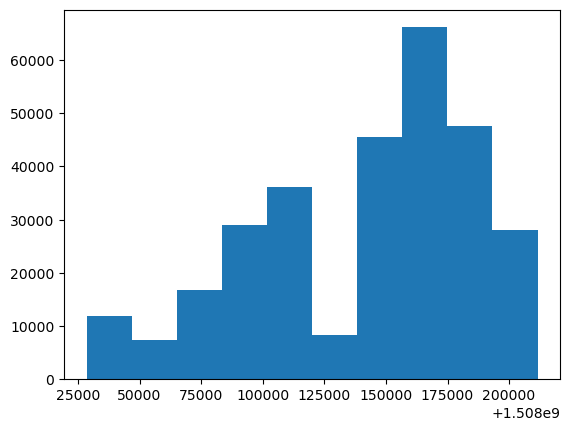

In [16]:
import matplotlib.pyplot as plt
plt.hist(interaction_matrix.timestamps_lte(t_10).timestamps.values)

In [17]:
interaction_matrix.timestamps.values
t_80 = interaction_matrix.timestamps.values[int(0.8 * len(interaction_matrix.timestamps.values))]
t_validate_80 = interaction_matrix.timestamps.values[int(0.8 * 0.8 * len(interaction_matrix.timestamps.values))]
print(t_80, t_validate_80)

1508184661.438 1508164951.091


In [ ]:
scenario = TimedLastItemPrediction(t = t_80, t_validation = t_validate_80, validation=True)
scenario.split(interaction_matrix)

## Experimental RecPack Pipeline

In [19]:
pipeline_builder = PipelineBuilder()
ok = (scenario._validation_data_in, scenario._validation_data_out)
pipeline_builder.set_data_from_scenario(scenario)


# Add the baseline algorithms
#pipeline_builder.add_algorithm('ItemKNN', grid={'K': [100, 200, 400, 800]})
#pipeline_builder.add_algorithm('EASE', grid={'l2': [10, 100, 1000], 'alpha': [0, 0.1, 0.5]})

# Add our LightGCN algorithm
pipeline_builder.add_algorithm(
    'PinSAGEAlgorithm2',
    grid={
        'learning_rate': [0.1, 0.01, 0.001],
        'embedding_dim': [100, 200, 400]
    },
    params={
        'max_epochs': 5,
        'batch_size': 1024,
        'n_layers': 3
    }
)

# Add NDCG, Recall, and HR metrics to be evaluated at 10, 20, and 50
pipeline_builder.add_metric('NDCGK', [10, 20, 50])
pipeline_builder.add_metric('RecallK', [10, 20, 50])
pipeline_builder.add_metric('HitK', [10, 20, 50])

# Set the optimisation metric
pipeline_builder.set_optimisation_metric('RecallK', 20)

# Construct pipeline
pipeline = pipeline_builder.build()

# Debugging: Output the shape of the training data
#print(f"Training data shape: {im.shape}")

# Run pipeline, will first do optimisation, and then evaluation
pipeline.run()

/opt/conda/lib/python3.11/site-packages/recpack/pipelines/pipeline_builder.py:145: UserWarning: Grid parameter for add_algorithm function will be deprecated in favour of optimisation_info.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_12380/2405251189.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_12380/2405251189.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_12380/2405251189.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 06:41:49,695 - base - recpack - INFO - Processed epoch 0 in 5.36 s.Batch Training Loss = 0.3828
2024-08-06 06:42:55,286 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.48325554580506336, which is better than previous iterations.
2024-08-06 06:42:55,287 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 06:42:55,372 - base - recpack - INFO - Evaluation at end of 0 took 65.67 s.
2024-08-06 06:42:59,485 - base - recpack - INFO - Processed epoch 1 in 4.11 s.Batch Training Loss = 0.3766
2024-08-06 06:44:03,808 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.49125993821872704, which is worse than previous iterations.
2024-08-06 06:44:03,818 - base - recpack - INFO - Evaluation at end of 1 took 64.33 s.
2024-08-06 06:44:07,911 - base - recpack - INFO - Processed epoch 2 in 4.09 s.Batch Training Loss = 0.3766
2024-08-06 06:45:12,093 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.48913905931439

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 06:48:40,514 - base - recpack - INFO - Processed epoch 0 in 4.03 s.Batch Training Loss = 0.3835
2024-08-06 06:49:46,335 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4546043579312428, which is better than previous iterations.
2024-08-06 06:49:46,337 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 06:49:46,402 - base - recpack - INFO - Evaluation at end of 0 took 65.89 s.
2024-08-06 06:49:50,244 - base - recpack - INFO - Processed epoch 1 in 3.84 s.Batch Training Loss = 0.3744
2024-08-06 06:50:55,283 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4538584364796979, which is worse than previous iterations.
2024-08-06 06:50:55,290 - base - recpack - INFO - Evaluation at end of 1 took 65.04 s.
2024-08-06 06:50:59,205 - base - recpack - INFO - Processed epoch 2 in 3.91 s.Batch Training Loss = 0.3748
2024-08-06 06:52:04,766 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4525924846342736

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 06:55:34,448 - base - recpack - INFO - Processed epoch 0 in 3.89 s.Batch Training Loss = 0.4124
2024-08-06 06:56:56,412 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4549837045186384, which is better than previous iterations.
2024-08-06 06:56:56,413 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 06:56:56,476 - base - recpack - INFO - Evaluation at end of 0 took 82.03 s.
2024-08-06 06:57:00,366 - base - recpack - INFO - Processed epoch 1 in 3.89 s.Batch Training Loss = 0.3671
2024-08-06 06:58:26,841 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4477140632936372, which is worse than previous iterations.
2024-08-06 06:58:26,846 - base - recpack - INFO - Evaluation at end of 1 took 86.48 s.
2024-08-06 06:58:30,694 - base - recpack - INFO - Processed epoch 2 in 3.85 s.Batch Training Loss = 0.3661
2024-08-06 06:59:52,761 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4449495464175136

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 07:05:16,680 - base - recpack - INFO - Processed epoch 0 in 6.48 s.Batch Training Loss = 0.3829
2024-08-06 07:06:24,464 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4894653502388297, which is better than previous iterations.
2024-08-06 07:06:24,465 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:06:24,578 - base - recpack - INFO - Evaluation at end of 0 took 67.90 s.
2024-08-06 07:06:30,894 - base - recpack - INFO - Processed epoch 1 in 6.31 s.Batch Training Loss = 0.3740
2024-08-06 07:07:37,968 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4629302556920116, which is better than previous iterations.
2024-08-06 07:07:37,969 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:07:38,100 - base - recpack - INFO - Evaluation at end of 1 took 67.21 s.
2024-08-06 07:07:44,447 - base - recpack - INFO - Processed epoch 2 in 6.35 s.Batch Training Loss = 0.3732
2024-08-06 07:08:51,2

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 07:12:38,585 - base - recpack - INFO - Processed epoch 0 in 6.35 s.Batch Training Loss = 0.3825
2024-08-06 07:13:40,292 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.45312397881485805, which is better than previous iterations.
2024-08-06 07:13:40,293 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:13:40,416 - base - recpack - INFO - Evaluation at end of 0 took 61.83 s.
2024-08-06 07:13:46,844 - base - recpack - INFO - Processed epoch 1 in 6.43 s.Batch Training Loss = 0.3742
2024-08-06 07:14:48,889 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.45306533078683237, which is worse than previous iterations.
2024-08-06 07:14:48,891 - base - recpack - INFO - Evaluation at end of 1 took 62.04 s.
2024-08-06 07:14:55,207 - base - recpack - INFO - Processed epoch 2 in 6.32 s.Batch Training Loss = 0.3744
2024-08-06 07:15:57,995 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.45355577308098

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 07:19:27,819 - base - recpack - INFO - Processed epoch 0 in 6.33 s.Batch Training Loss = 0.3991
2024-08-06 07:20:45,806 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4461620487847059, which is better than previous iterations.
2024-08-06 07:20:45,807 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:20:45,926 - base - recpack - INFO - Evaluation at end of 0 took 78.11 s.
2024-08-06 07:20:52,526 - base - recpack - INFO - Processed epoch 1 in 6.60 s.Batch Training Loss = 0.3667
2024-08-06 07:22:26,109 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.44653086947464515, which is worse than previous iterations.
2024-08-06 07:22:26,114 - base - recpack - INFO - Evaluation at end of 1 took 93.59 s.
2024-08-06 07:22:32,457 - base - recpack - INFO - Processed epoch 2 in 6.34 s.Batch Training Loss = 0.3670
2024-08-06 07:24:10,686 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.450995769179952

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 07:29:06,275 - base - recpack - INFO - Processed epoch 0 in 12.51 s.Batch Training Loss = 0.3800
2024-08-06 07:30:12,446 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.45022748609079244, which is better than previous iterations.
2024-08-06 07:30:12,447 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:30:12,683 - base - recpack - INFO - Evaluation at end of 0 took 66.41 s.
2024-08-06 07:30:25,376 - base - recpack - INFO - Processed epoch 1 in 12.69 s.Batch Training Loss = 0.3732
2024-08-06 07:31:30,991 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.45086434361457944, which is worse than previous iterations.
2024-08-06 07:31:30,992 - base - recpack - INFO - Evaluation at end of 1 took 65.61 s.
2024-08-06 07:31:43,571 - base - recpack - INFO - Processed epoch 2 in 12.58 s.Batch Training Loss = 0.3737
2024-08-06 07:32:48,166 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.45064333450

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 07:36:45,605 - base - recpack - INFO - Processed epoch 0 in 12.54 s.Batch Training Loss = 0.3822
2024-08-06 07:37:48,528 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4694608313129426, which is better than previous iterations.
2024-08-06 07:37:48,529 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:37:48,753 - base - recpack - INFO - Evaluation at end of 0 took 63.15 s.
2024-08-06 07:38:01,204 - base - recpack - INFO - Processed epoch 1 in 12.45 s.Batch Training Loss = 0.3750
2024-08-06 07:39:03,604 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.47132955913918, which is worse than previous iterations.
2024-08-06 07:39:03,608 - base - recpack - INFO - Evaluation at end of 1 took 62.40 s.
2024-08-06 07:39:16,121 - base - recpack - INFO - Processed epoch 2 in 12.51 s.Batch Training Loss = 0.3749
2024-08-06 07:40:18,156 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.472427152134635

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 07:44:06,697 - base - recpack - INFO - Processed epoch 0 in 12.51 s.Batch Training Loss = 0.3903
2024-08-06 07:45:15,047 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.464203308326714, which is better than previous iterations.
2024-08-06 07:45:15,048 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:45:15,284 - base - recpack - INFO - Evaluation at end of 0 took 68.59 s.
2024-08-06 07:45:27,876 - base - recpack - INFO - Processed epoch 1 in 12.59 s.Batch Training Loss = 0.3682
2024-08-06 07:46:36,830 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.46213543385375927, which is worse than previous iterations.
2024-08-06 07:46:36,832 - base - recpack - INFO - Evaluation at end of 1 took 68.95 s.
2024-08-06 07:46:49,215 - base - recpack - INFO - Processed epoch 2 in 12.38 s.Batch Training Loss = 0.3672
2024-08-06 07:48:01,664 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4624159209816

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-06 07:52:44,127 - base - recpack - INFO - Processed epoch 0 in 12.50 s.Batch Training Loss = 0.3906
2024-08-06 07:53:56,222 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.45909298385764624, which is better than previous iterations.
2024-08-06 07:53:56,223 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:53:56,468 - base - recpack - INFO - Evaluation at end of 0 took 72.34 s.
2024-08-06 07:54:08,993 - base - recpack - INFO - Processed epoch 1 in 12.52 s.Batch Training Loss = 0.3687
2024-08-06 07:55:19,439 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.44663511513134063, which is better than previous iterations.
2024-08-06 07:55:19,440 - base - recpack - INFO - Model improved. Storing better model.
2024-08-06 07:55:19,717 - base - recpack - INFO - Evaluation at end of 1 took 70.72 s.
2024-08-06 07:55:32,189 - base - recpack - INFO - Processed epoch 2 in 12.47 s.Batch Training Loss = 0.3667
2024-08-06 07:56

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)


## Results

In [20]:
pipeline.get_metrics()

,NDCGK_10,NDCGK_20,NDCGK_50,RecallK_10,RecallK_20,RecallK_50,HitK_10,HitK_20,HitK_50
"PinSAGEAlgorithm(batch_size=1024,dropout=0.1,embedding_dim=400,grad_clip=1.0,keep_last=False,learning_rate=0.001,max_epochs=5,max_iter_no_change=5,min_improvement=0.01,n_layers=3,predict_topK=None,save_best_to_file=False,seed=4068379196,stop_early=True,stopping_criterion=<recpack.algorithms.stopping_criterion.StoppingCriterion object at 0x7f0688d1bbd0>,validation_sample_size=None)",0.007734,0.010171,0.017054,0.015133,0.02487,0.060531,0.015133,0.02487,0.060531
